In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('FCallSessions.csv')
# create a long format for analysis
df.describe()

,groupIdx,amg_hippPost1,amg_vmPFC1,amg_HippAnt1,amg_vmPFCAnt1,hippAnt_vmPFCAnt1,hippAnt_hippPost1,amg_hippPost2,amg_vmPFC2,amg_hippAnt2,...,amg_hippAnt3,amg_vmPFCAnt3,hippAnt_vmPFCAnt3,hippAnt_hippPost3,amg_hippPost4,amg_vmPFC4,amg_hippAnt4,amg_vmPFCAnt4,hippAnt_vmPFCAnt4,hippAnt_hippPost4
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,25.000000,25.000000,25.000000,...,22.000000,22.000000,22.000000,22.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.500000,0.271148,0.513186,0.271258,0.349830,0.217479,0.304504,0.296642,0.364202,0.316405,...,0.271146,0.214985,0.178116,0.425026,0.162026,0.363819,0.248858,0.314005,0.076422,0.335956
std,0.509902,0.198495,0.226282,0.263443,0.222321,0.301799,0.256845,0.297025,0.219025,0.240962,...,0.267546,0.292768,0.299988,0.193779,0.342823,0.319029,0.231000,0.255233,0.252961,0.205687
min,0.000000,-0.096844,-0.055699,-0.192782,-0.349564,-0.469990,-0.250251,-0.254465,-0.272251,-0.214743,...,-0.189834,-0.385748,-0.460460,-0.029337,-0.479055,-0.142419,-0.115037,-0.061807,-0.324347,-0.133583
25%,0.000000,0.121527,0.351217,0.139287,0.257461,0.093451,0.171554,0.073380,0.239052,0.097621,...,0.094045,0.066558,0.014552,0.289250,-0.116818,0.060517,0.029720,0.115222,-0.108495,0.250125
50%,0.500000,0.272865,0.577810,0.263428,0.385805,0.238740,0.317298,0.380831,0.365332,0.382710,...,0.301530,0.249703,0.176067,0.489939,0.239219,0.392061,0.295949,0.388116,0.028039,0.359252
75%,1.000000,0.420370,0.673977,0.393543,0.477417,0.406410,0.540128,0.553591,0.488261,0.502424,...,0.448451,0.413853,0.458328,0.550105,0.397470,0.665525,0.429344,0.505272,0.281719,0.422300
max,1.000000,0.606122,0.774370,0.750596,0.646947,0.662831,0.648514,0.698112,0.675950,0.733511,...,0.751112,0.740254,0.662622,0.694430,0.641858,0.748723,0.638357,0.760333,0.527674,0.643018


## Amygdala Hippocampus

In [4]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_hippPost1','amg_hippPost2',
                                                                         'amg_hippPost3'])

In [5]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                          \
                       count      mean       std       min       25%   
groupIdx variable                                                      
0        amg_hippPost1  13.0  0.232713  0.156011  0.005189  0.108381   
         amg_hippPost2  12.0  0.438861  0.180178  0.073380  0.381203   
         amg_hippPost3  10.0  0.292109  0.357691 -0.366046  0.101157   
1        amg_hippPost1  13.0  0.309582  0.233546 -0.096844  0.160964   
         amg_hippPost2  13.0  0.165363  0.328317 -0.254465 -0.128545   
         amg_hippPost3  12.0  0.376429  0.265625 -0.131075  0.229355   

                                                      
                             50%       75%       max  
groupIdx variable                                     
0        amg_hippPost1  0.234275  0.332985  0.494981  
         amg_hippPost2  0.472924  0.578617  0.633108  
         amg_hippPost3  0.229846  0.567329  0.788340  
1        amg_hippPost1  0.302873  0.486021  0.606122  
         amg_hippPost2  0.124015  0.380831  0.698112  
         amg_hippPost3  0.396978  0.505380  0.807860

In [6]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value   
No. Observations:          73             Method:                    REML    
No. Groups:                26             Scale:                     0.0601  
Min. group size:           2              Log-Likelihood:            -11.8762
Max. group size:           3              Converged:                 Yes     
Mean group size:           2.8                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.233    0.072  3.230 0.001  0.092  0.374
variable[T.amg_hippPost2]           0.203    0.098  2.065 0.039  0.010  0.396
variable[T.amg_hippPost3]           0.058    0.104  0.562 0.574 -0.145  0.262
groupI

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.042      1     19  0.042  0.452    0.509  0.023  nan
variable     0.052      2     38  0.026  0.421    0.660  0.022    0.971
Interaction  0.263      2     38  0.132  2.146    0.131  0.101  nan



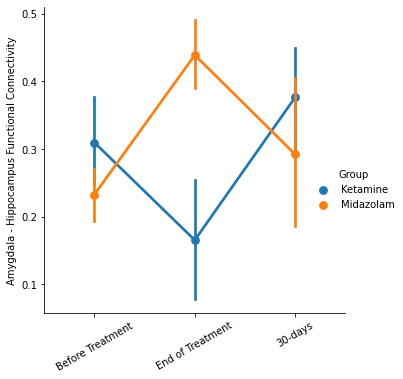

In [9]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_postHipp_FC.png', dpi=600, bbox_inches='tight')

In [9]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values 
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_hippPost1','amg_hippPost2','amg_hippPost3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [10]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
   
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

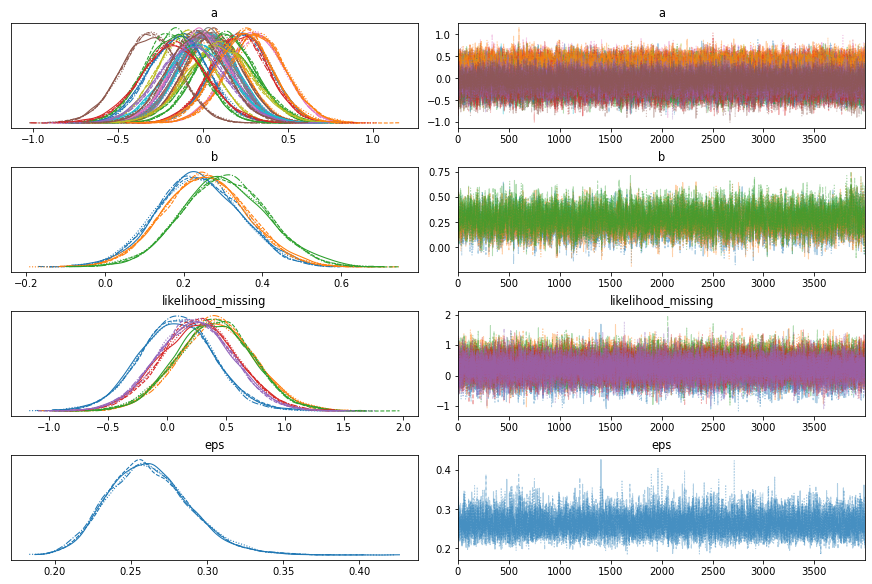

In [11]:
az.plot_trace(trace)

In [12]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.008,0.171,-0.288,0.273,0.002,0.002,6511.0,9436.0,1.0
a[1],0.069,0.170,-0.206,0.351,0.002,0.001,7015.0,10036.0,1.0
a[2],0.114,0.197,-0.208,0.441,0.002,0.002,7887.0,10355.0,1.0
a[3],0.024,0.172,-0.258,0.303,0.002,0.001,7113.0,9703.0,1.0
a[4],0.030,0.170,-0.247,0.312,0.002,0.001,7013.0,9793.0,1.0
a[5],0.059,0.170,-0.216,0.341,0.002,0.001,6896.0,10172.0,1.0
a[6],0.309,0.169,0.039,0.593,0.002,0.001,6611.0,9612.0,1.0
a[7],-0.013,0.170,-0.290,0.267,0.002,0.001,6483.0,9144.0,1.0
a[8],-0.100,0.169,-0.381,0.174,0.002,0.001,6448.0,9264.0,1.0
a[9],0.027,0.172,-0.265,0.301,0.002,0.001,6720.0,9353.0,1.0


0.5931875


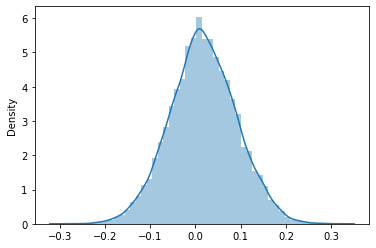

In [13]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.7991875


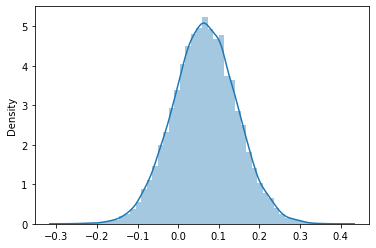

In [14]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [15]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.231,0.062,0.131,0.337,0.002,0.001,1700.0,1939.0,1.0
groupIdx,0.078,0.088,-0.076,0.215,0.002,0.002,1724.0,1990.0,1.0
sd,0.211,0.033,0.161,0.264,0.001,0.001,1866.0,1801.0,1.0


In [16]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.441,0.084,0.297,0.571,0.002,0.001,1856.0,2229.0,1.0
groupIdx,-0.278,0.115,-0.460,-0.085,0.003,0.002,1807.0,2255.0,1.0
sd,0.283,0.046,0.213,0.352,0.001,0.001,2053.0,1925.0,1.0


In [17]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8866409003831651, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.290,0.108,0.103,0.451,0.003,0.002,1748.0,2046.0,1.0
groupIdx,0.087,0.145,-0.150,0.320,0.003,0.002,1790.0,1946.0,1.0
sd,0.332,0.057,0.246,0.416,0.001,0.001,2024.0,2047.0,1.0


- Between amygdala and posterior hippocampus there's a difference only after treatment. With Ketamine shows lower connectivity, compared to midazolam.

## Amygdala and vmPFC

In [10]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_vmPFC1','amg_vmPFC2',
                                                                         'amg_vmPFC3'])

In [11]:
df_long.groupby(['variable','groupIdx']).describe()

value                                                    \
                    count      mean       std       min       25%       50%   
variable   groupIdx                                                           
amg_vmPFC1 0         13.0  0.476762  0.232118 -0.055699  0.342115  0.523917   
           1         13.0  0.549611  0.223429 -0.009363  0.565582  0.620574   
amg_vmPFC2 0         12.0  0.319887  0.228887 -0.272251  0.231635  0.344384   
           1         13.0  0.405109  0.210103  0.004965  0.310339  0.381881   
amg_vmPFC3 0         10.0  0.486395  0.153387  0.196863  0.432737  0.483726   
           1         12.0  0.344969  0.250293 -0.146157  0.263921  0.324898   

                                         
                          75%       max  
variable   groupIdx                      
amg_vmPFC1 0         0.631171  0.774370  
           1         0.677530  0.766076  
amg_vmPFC2 0         0.472607  0.615081  
           1         0.575514  0.675950  
amg_vmPFC3 0         0.568808  0.753866  
           1         0.526263  0.709229

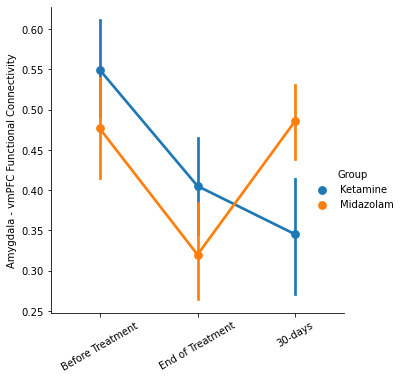

In [13]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point',
           ci=68, hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - vmPFC Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine','Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_vmpfc_FC.png', dpi=600, bbox_inches='tight')

In [12]:
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.018      1     19  0.018  0.406    0.531  0.021  nan
variable     0.436      2     38  0.218  4.436    0.019  0.189    0.984
Interaction  0.140      2     38  0.070  1.419    0.254  0.070  nan



In [13]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        value  
No. Observations:        73             Method:                    REML   
No. Groups:              26             Scale:                     0.0483 
Min. group size:         2              Log-Likelihood:            -1.2050
Max. group size:         3              Converged:                 Yes    
Mean group size:         2.8                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.477    0.061  7.802 0.000  0.357  0.597
variable[T.amg_vmPFC2]          -0.157    0.088 -1.782 0.075 -0.330  0.016
variable[T.amg_vmPFC3]           0.009    0.093  0.101 0.919 -0.172  0.191
groupIdx                         0.073    0.

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [14]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [15]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

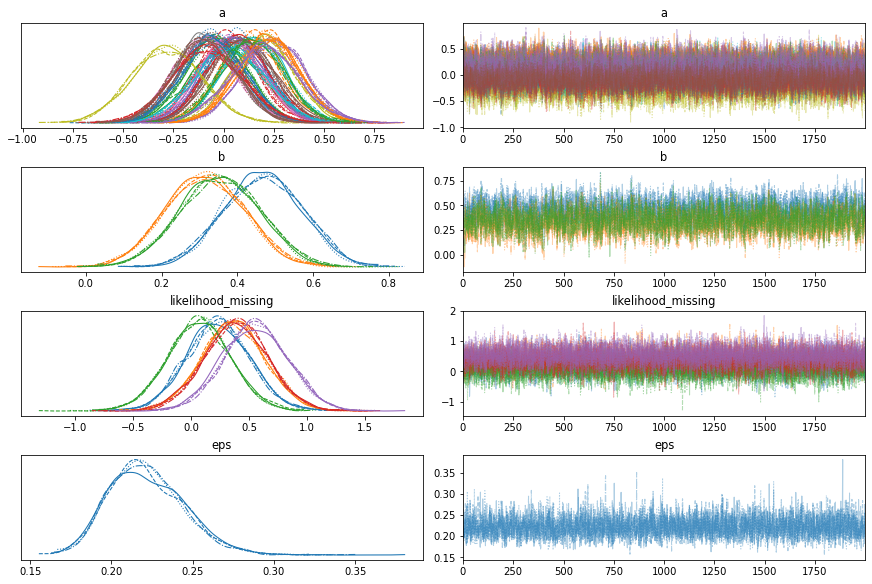

In [16]:
az.plot_trace(trace)

In [24]:
az.summary(trace, hdi_prob=.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.069,0.155,-0.340,0.171,0.003,0.002,1956.0,4264.0,1.00
a[1],0.132,0.158,-0.135,0.382,0.003,0.002,2592.0,4597.0,1.00
a[2],0.017,0.177,-0.270,0.314,0.003,0.002,2657.0,5023.0,1.00
a[3],0.020,0.154,-0.229,0.269,0.003,0.002,2259.0,4665.0,1.00
a[4],0.258,0.155,0.011,0.512,0.003,0.002,2128.0,4078.0,1.00
a[5],-0.063,0.154,-0.308,0.194,0.003,0.002,2411.0,4695.0,1.00
a[6],0.033,0.155,-0.211,0.300,0.004,0.003,1903.0,3994.0,1.00
a[7],0.082,0.156,-0.183,0.331,0.003,0.002,2034.0,4028.0,1.00
a[8],0.197,0.155,-0.063,0.444,0.004,0.003,1806.0,4575.0,1.01
a[9],0.148,0.152,-0.106,0.390,0.003,0.002,2064.0,4532.0,1.00


<AxesSubplot:ylabel='Density'>

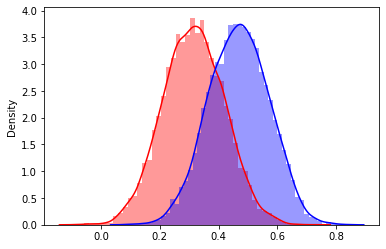

In [69]:
## what are the chances that amygdala-vmpfc connectivity was higher given the current data
sns.distplot(trace['b'][500:,1], color='red')
#sns.distplot(trace['b'][500:,2], color = 'maroon')
sns.distplot(trace['b'][500:,0], color='blue')


In [55]:
# calculating the overlap between the two distributions
y2 = trace['b'][:,0]
y1 = trace['b'][:,1]
from scipy import stats

xmin, xmax = -4., 4.
x_pts = np.mgrid[xmin:xmax:3000]


ker_b = stats.gaussian_kde(y1)
ker_a = stats.gaussian_kde(y2)
kde_a = np.reshape(ker_a(x_pts).T, x_pts.shape)
kde_b = np.reshape(ker_b(x_pts).T, x_pts.shape)


# Random sample from a KDE distribution.
sample = ker_a.resample(size=3000)

# Compute the points below which to integrate.
iso = ker_b(sample)

# Filter the sample.
insample = ker_a(sample) < iso

# As per Monte Carlo, the integral is equivalent to the
# probability of drawing a point that gets through the
# filter.
integral = insample.sum() / float(insample.shape[0])

integral


0.22966666666666666

sns.distplot(sample)
sns.distplot(y1)
#sns.distplot(iso)
insample

0.01075


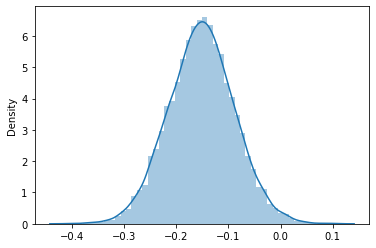

In [25]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.04475


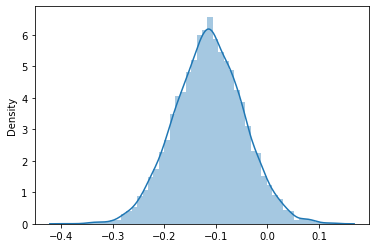

In [26]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

Differences between groups

In [27]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8814991716390949, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.475,0.069,0.36,0.583,0.002,0.001,1563.0,1953.0,1.0
groupIdx,0.074,0.099,-0.08,0.238,0.002,0.002,1682.0,2058.0,1.0
sd,0.241,0.038,0.18,0.299,0.001,0.001,1966.0,1748.0,1.0


In [28]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.318,0.068,0.206,0.426,0.002,0.001,1770.0,2041.0,1.0
groupIdx,0.087,0.094,-0.058,0.252,0.002,0.002,1681.0,1947.0,1.0
sd,0.231,0.037,0.168,0.287,0.001,0.001,1468.0,1377.0,1.0


In [29]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.485,0.071,0.368,0.602,0.002,0.001,1710.0,2105.0,1.0
groupIdx,-0.141,0.097,-0.306,0.012,0.002,0.002,1748.0,2211.0,1.0
sd,0.225,0.038,0.167,0.284,0.001,0.001,2114.0,1915.0,1.0


- Adding testing of declind within group and between time periods

In [30]:
# Just midazolam
df_longM = df_long[df_long.groupIdx==0]
glm = smf.mixedlm('value ~ variable', data=df_longM, groups = df_longM.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value 
No. Observations:      35          Method:                 REML  
No. Groups:            13          Scale:                  0.0418
Min. group size:       2           Log-Likelihood:         0.6520
Max. group size:       3           Converged:              Yes   
Mean group size:       2.7                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.477    0.059  8.117 0.000  0.362  0.592
variable[T.amg_vmPFC2] -0.159    0.082 -1.932 0.053 -0.319  0.002
variable[T.amg_vmPFC3]  0.006    0.087  0.070 0.945 -0.164  0.176
Group Var               0.003    0.050                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [31]:
# Just Ketamine
df_longK = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longK, groups = df_longK.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     38          Method:                 REML   
No. Groups:           13          Scale:                  0.0519 
Min. group size:      2           Log-Likelihood:         -1.7109
Max. group size:      3           Converged:              Yes    
Mean group size:      2.9                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.550    0.063  8.695 0.000  0.426  0.673
variable[T.amg_vmPFC2] -0.145    0.089 -1.617 0.106 -0.320  0.031
variable[T.amg_vmPFC3] -0.205    0.091 -2.241 0.025 -0.384 -0.026
Group Var               0.000    0.042                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [32]:
# lets test the 30 days vs. before trt
#pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0])
pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.799741,9,two-sided,0.444455,"[-0.09, 0.2]",0.304903,0.403,0.139044


In [33]:
pg.ttest(df.amg_vmPFC1[df.groupIdx==1], df.amg_vmPFC3[df.groupIdx==1], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.782662,11,two-sided,0.102227,"[-0.05, 0.45]",0.833364,0.973,0.748124


In [40]:
## Same but Bayes
# generate two different data sets
def runBayes(df):
    
    df['scr_id'] = df.scr_id.astype('category')
    sub_idx = df.scr_id.cat.codes.values # 
    print(sub_idx)
    n_subs = len(np.unique(df.scr_id))
    print(n_subs)
    # set time as index also
    #df_long.groupIdx = pd.Categorical(df_long.groupIdx)
    df.variable = pd.Categorical(df.variable, 
                        categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
    timeIDX = df.variable.cat.codes.values
    print(timeIDX)
    df['time'] = timeIDX
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)

        b = pm.Normal('b', mu=0, sd=0.5, shape=3)
     
        eps = pm.HalfCauchy('eps', 3)

        y_hat = a[sub_idx] + b[timeIDX] 

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df.value)

        trace = pm.sample(draws=1000, tune=2000, target_accept=0.9, return_inferencedata=False)
    return trace

In [53]:
df_longMR = df_longM.reset_index(drop=True) # need to reset the indices

df_longMR.scr_id.cat.values
#traceM = runBayes(df_longMR)

AttributeError: 'CategoricalAccessor' object has no attribute 'values'

In [44]:
df_longMR['scr_id'] = df_longMR.scr_id.astype('category')
df_longMR.scr_id.cat.codes

0      2
1      3
2      9
3     10
4     11
5     12
6     14
7     15
8     18
9     19
10    21
11    23
12    25
13     2
14     3
15     9
16    10
17    11
18    12
19    14
20    15
21    18
22    19
23    21
24    23
25    25
26     2
27     3
28     9
29    10
30    11
31    12
32    14
33    15
34    18
35    19
36    21
37    23
38    25
dtype: int8

0.02525


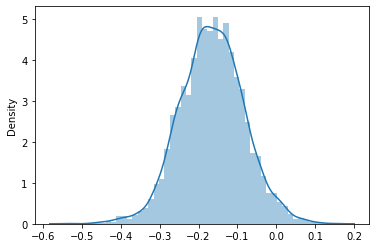

In [90]:
diff = traceM['b'][:,1] - traceM['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [37]:
# same for K
df_longKR = df_longK.reset_index(drop=True) # need to reset the indices
df_longKR
traceK = runBayes(df_longKR)

[ 0  1  4  5  6  7  8 13 16 17 20 22 24  0  1  4  5  6  7  8 13 16 17 20
 22 24  0  1  4  5  6  7  8 13 16 17 20 22 24]
13
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2]


IndexError: index 13 is out of bounds for axis 0 with size 13

0.02375


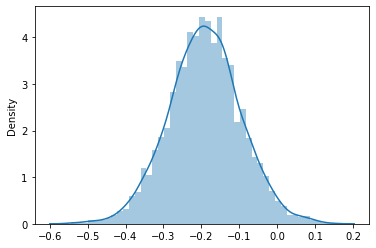

In [94]:
diff = traceK['b'][:,2] - traceK['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

## Amygdala anterior hippocampus

In [4]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_HippAnt1','amg_hippAnt2',
                                                                         'amg_hippAnt3'])

In [5]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                                    \
                      count      mean       std       min       25%       50%   
groupIdx variable                                                               
0        amg_HippAnt1  13.0  0.214479  0.273074 -0.188385  0.123616  0.190337   
         amg_hippAnt2  12.0  0.299227  0.242692 -0.090673  0.090065  0.312811   
         amg_hippAnt3  10.0  0.205291  0.291547 -0.189834 -0.007372  0.195007   
1        amg_HippAnt1  13.0  0.328036  0.251066 -0.192782  0.202590  0.357378   
         amg_hippAnt2  13.0  0.332262  0.248127 -0.214743  0.183082  0.385195   
         amg_hippAnt3  12.0  0.326026  0.244706 -0.037593  0.125349  0.326469   

                                           
                            75%       max  
groupIdx variable                          
0        amg_HippAnt1  0.363448  0.750596  
         amg_hippAnt2  0.429742  0.733511  
         amg_hippAnt3  0.430613  0.657238  
1        amg_HippAnt1  0.394092  0.730621  
         amg_hippAnt2  0.522014  0.609480  
         amg_hippAnt3  0.484287  0.751112

In [6]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        value   
No. Observations:         73             Method:                    REML    
No. Groups:               26             Scale:                     0.0594  
Min. group size:          2              Log-Likelihood:            -11.4768
Max. group size:          3              Converged:                 Yes     
Mean group size:          2.8                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.214    0.072  2.995 0.003  0.074  0.355
variable[T.amg_hippAnt2]           0.078    0.098  0.798 0.425 -0.114  0.270
variable[T.amg_hippAnt3]          -0.008    0.103 -0.081 0.935 -0.211  0.194
groupIdx           

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.051      1     19  0.051  0.716    0.408  0.036  nan
variable     0.001      2     38  0.001  0.012    0.988  0.001    0.994
Interaction  0.009      2     38  0.005  0.073    0.930  0.004  nan



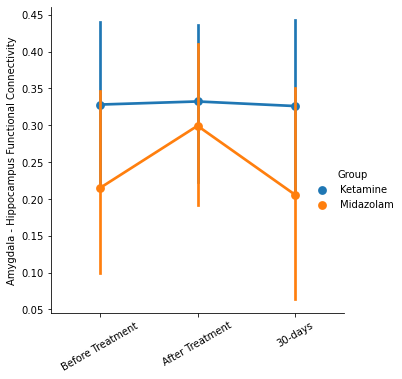

In [8]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=90,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [18]:
pg.ttest(df.amg_hippAnt2[df.groupIdx==1], df.amg_hippAnt2[df.groupIdx==0], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.336074,23,two-sided,0.739862,"[-0.17, 0.24]",0.134537,0.384,0.061981


In [10]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_HippAnt1','amg_hippAnt2','amg_hippAnt3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [11]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    traceamgAntHipp = pm.sample(draws=2000, tune=2000, target_accept=0.9, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [12]:
az.summary(traceamgAntHipp,hdi_prob=0.9 )

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.069,0.158,-0.324,0.197,0.003,0.002,3383.0,5143.0,1.0
a[1],-0.073,0.159,-0.353,0.174,0.003,0.002,3147.0,4679.0,1.0
a[2],-0.221,0.182,-0.522,0.073,0.003,0.002,3614.0,5235.0,1.0
a[3],0.070,0.161,-0.194,0.334,0.003,0.002,2917.0,4664.0,1.0
a[4],0.128,0.163,-0.151,0.385,0.003,0.002,3231.0,4982.0,1.0
a[5],-0.098,0.159,-0.362,0.165,0.003,0.002,3175.0,4734.0,1.0
a[6],0.105,0.159,-0.169,0.352,0.003,0.002,3448.0,4925.0,1.0
a[7],0.259,0.158,0.002,0.516,0.003,0.002,3173.0,5209.0,1.0
a[8],0.146,0.159,-0.113,0.410,0.003,0.002,3261.0,5345.0,1.0
a[9],-0.328,0.159,-0.580,-0.062,0.003,0.002,3246.0,5339.0,1.0


0.666


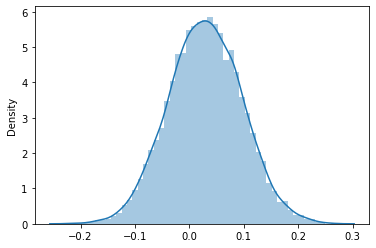

In [14]:
diff = traceamgAntHipp['b'][:,1] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

0.508


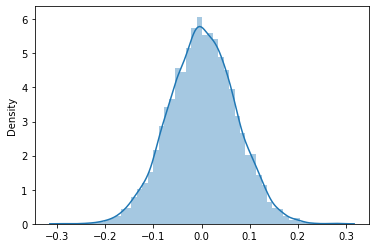

In [15]:
diff = traceamgAntHipp['b'][:,2] - traceamgAntHipp['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [19]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_HippAnt1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.214,0.084,0.084,0.350,0.002,0.002,1493.0,1986.0,1.0
groupIdx,0.114,0.117,-0.065,0.313,0.003,0.002,1307.0,1990.0,1.0
sd,0.279,0.044,0.212,0.352,0.001,0.001,1801.0,1638.0,1.0


In [20]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.300,0.077,0.176,0.428,0.002,0.001,1749.0,1874.0,1.0
groupIdx,0.031,0.108,-0.136,0.211,0.003,0.002,1765.0,1962.0,1.0
sd,0.260,0.042,0.191,0.322,0.001,0.001,1609.0,1620.0,1.0


In [21]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippAnt3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8971491089396249, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.206,0.095,0.057,0.370,0.002,0.002,1503.0,1437.0,1.0
groupIdx,0.120,0.129,-0.095,0.329,0.003,0.002,1510.0,1613.0,1.0
sd,0.287,0.051,0.211,0.368,0.001,0.001,1664.0,1783.0,1.0
